In [2]:
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
# Importing the Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

random_state=42

<h2>Helper Functions</h2>

In [4]:
# Tweets preprocessing.

stopw = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):

    tweet = tweet.lower()

    # Remove twitter handels (@user)
    tweet = re.sub("@[a-z0-9:]+", "", tweet)

    # Remove RT
    tweet = re.sub("rt ", "", tweet)

    # Remove http links
    tweet = re.sub(r"http\S+", "", tweet) 
    

    # Remove hashtag sign but keep the text
    tweet = tweet.replace("#", "").replace("_", " ") 

    # Remove punctuations
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)

    # Remove all non-alphanumeric character
    tweet = re.sub("[^a-z0-9]"," ", tweet)

    # Stop word removal and lemmatization
    tweet = tweet.split()
    tweet = [w for w in tweet if not w in stopw]
    tweet = [lemmatizer.lemmatize(w) for w in tweet ]
    tweet = " ".join(word for word in tweet)

    return tweet
    
def remove_emoji(text):
    return emoji.replace_emoji(text, replace='')

In [8]:
def wrapper(train, test):
    # Apply tweets preprocessing.
    train["message_clean"] = train["message"].apply(lambda x: clean_tweet(x))
    test["message_clean"] = test["message"].apply(lambda x: clean_tweet(x))

    # Prepare datasets for ML model.
    X_train = train["message_clean"].values.reshape(-1, 1)
    y_train = train["sentiment"]

    X_test = test["message_clean"].values.reshape(-1, 1)
    y_test = test["sentiment"]

    # Balancing.
    sampler = RandomOverSampler(random_state=random_state)
    X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)

    # Create the Decision Tree model.
    dt = DecisionTreeClassifier(random_state=random_state)

    # Create TF-IDF Vectorizer.
    tfidf_converter = TfidfVectorizer()

    # Create the pipeline.
    pipeline = Pipeline(steps=[("tf_idf", tfidf_converter), ("classification", dt)])

    # Search parameters for Bayesian optimization.
    param_grid = {
        "tf_idf__max_df": (0.7, 1.0),
        "tf_idf__min_df": (0.0, 0.3),
        "classification__max_depth": (10, 1500),
        "classification__min_samples_split": (2, 10),
        "classification__min_samples_leaf": (1, 10)
    }

    # n_iter, cv, and n_jobs can be adjusted to differentiate between accuracy and speed.
    bayes_search_estimator = BayesSearchCV(estimator=pipeline, search_spaces=param_grid, n_iter=20, cv=3, n_jobs=-2, random_state=random_state)

    # Fit the model.
    bayes_search_estimator.fit(X_train_sampled.ravel(), y_train_sampled)

    # Print best accuracy and hyperparameters.
    print(f"Best accuracy: {bayes_search_estimator.best_score_ * 100:.2f}%")
    print(f"Best hyperparameters: {bayes_search_estimator.best_params_}")

    # Get the best estimator from the Bayesian search.
    estimator = bayes_search_estimator.best_estimator_

    # Predict class labels.
    y_pred = estimator.predict(X_test.ravel())

    # Display classification report and confusion matrix.
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    plt.show()

    # Return best TF-IDF and ML model.
    return estimator["tf_idf"], estimator["classification"]


<h3>Machine Learning</h3>
Our sentiment analysis task is to predict whether a climate change related tweet and the beliefs it reflects falls into one of four categories:

- Anti (Climate change denier)
- Neutral (Neutral towards the topic)
- Pro (Climate change believer)
- Factual News (Factual news attached that cites a credible source towards the existence of climate change)

The first three categories are typical in the context of sentiment analysis, while the fourth category may be kind of out of place. Thus, we decided, in consultation with our tutor, that we test three approaches in handling this category:

Leave it as it is (Normal approach)
Drop all rows labelled as this class (Dropping approach)
Replacing it with the "Pro" label, as it could be interpreted that way (Replacing approach)
In the following, we will compare the results of all three approaches.

<h3>Normal approach</h3>

In [9]:
train = pd.read_csv("./data/trainset.csv")
test = pd.read_csv("./data/testset.csv")

In [10]:
display_dist(train)

Best accuracy: 83.47%
Best hyperparameters: OrderedDict([('classification__max_depth', 958), ('classification__min_samples_leaf', 1), ('classification__min_samples_split', 10), ('tf_idf__max_df', 0.7), ('tf_idf__min_df', 0.0)])
              precision    recall  f1-score   support

          -1       0.37      0.43      0.40       771
           0       0.40      0.43      0.41      1501
           1       0.70      0.61      0.65      4120
           2       0.55      0.65      0.60      1815

    accuracy                           0.57      8207
   macro avg       0.51      0.53      0.51      8207
weighted avg       0.58      0.57      0.57      8207



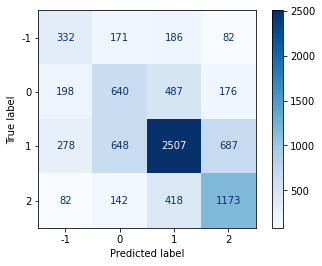

In [11]:
tf_idf_normal, dt_normal = wrapper(train, test)

<h3>Dropping approach</h3>

In [12]:
train_drop = train[train["sentiment"] != 2].copy(deep=True)
test_drop = test[test["sentiment"] != 2].copy(deep=True)

In [14]:
display_dist(train_drop)

Best accuracy: 84.76%
Best hyperparameters: OrderedDict([('classification__max_depth', 1303), ('classification__min_samples_leaf', 1), ('classification__min_samples_split', 8), ('tf_idf__max_df', 0.8749123645142688), ('tf_idf__min_df', 0.0013040056799145884)])
              precision    recall  f1-score   support

          -1       0.38      0.44      0.41       771
           0       0.41      0.48      0.44      1501
           1       0.79      0.71      0.75      4120

    accuracy                           0.63      6392
   macro avg       0.52      0.55      0.53      6392
weighted avg       0.65      0.63      0.64      6392



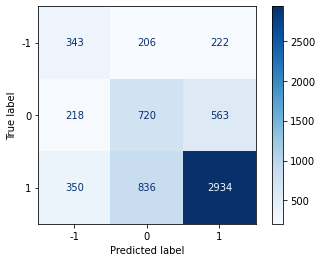

In [15]:
tf_idf_drop, dt_drop = wrapper(train_drop, test_drop)

<h3>Replacing approach</h3>

In [16]:
train_replace = train.copy(deep=True)
train_replace["sentiment"] = train_replace["sentiment"].replace(2, 1)

test_replace = test.copy(deep=True)
test_replace["sentiment"] = test_replace["sentiment"].replace(2, 1)

In [17]:
display_dist(train_replace)

Best accuracy: 44.19%
Best hyperparameters: OrderedDict([('classification__max_depth', 721), ('classification__min_samples_leaf', 2), ('classification__min_samples_split', 9), ('tf_idf__max_df', 0.9920761138198906), ('tf_idf__min_df', 0.09921316334650422)])
              precision    recall  f1-score   support

          -1       0.31      0.09      0.14       771
           0       0.33      0.40      0.36      1501
           1       0.80      0.83      0.82      5935

    accuracy                           0.68      8207
   macro avg       0.48      0.44      0.44      8207
weighted avg       0.67      0.68      0.67      8207



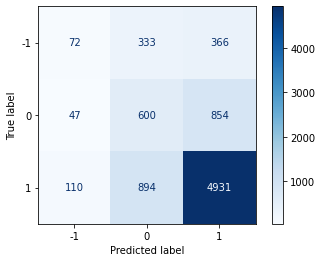

In [18]:
tf_idf_replace, dt_replace = wrapper(train_replace, test_replace)

<h4>The accuracy results speak for themselves:</h4>

- Normal approach: Train: 0.83, Test: 0.58
- Dropping approach: Train: 0.85, Test: 0.65
- Replacing approach: Train: 0.44, Test: 0.68
